#  CNN 실습_이미지분류

## 1.환경준비

### (1) 라이브러리 로딩

In [12]:
import cv2
# from google.colab.patches import cv2_imshow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

* 함수 만들기

In [13]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 구글드라이브 마운트

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

### (3) 원본 데이터 둘러보기
* 공유받은 폴더 'images'를 자신의 구글드라이브에 업로드 합니다.
* 업로드 위치 : 내드라이브 바로 아래!

* 데이터 목록 읽어오기

In [15]:
path = './images/dogs'
fileList = os.listdir(path)

* 이미지 파일 둘러보기
    * 아래 셀을 반복실행해 봅시다.

In [5]:
n = rd.randrange(0, len(fileList))
fileList[n]
file_r = path + '/' + fileList[n]
img = cv2.imread(file_r)
print(img.shape)
cv2.imshow('img',img)

(350, 229, 3)


## 2.이미지 전처리

* 이미지를 전처리하는 작업은 꽤 오래 걸리는 작업입니다.
* 아래 절차와 코드가 있지만, 중간 결과물을 이용하여 진행해 보도록 하겠습니다.

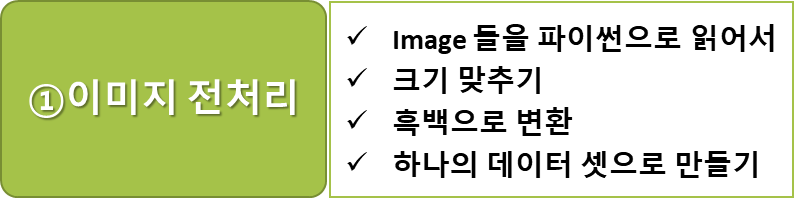

### (1) 파일 크기, 흑백 맞춰서 저장하기
* 흑백이미지
* 150 * 150 크기

* 아래 코드는 시간이 많이 소요되므로 이미 수행한 이미지를 사용합니다.
* 실제 데이터를 가지고 테스트할 때는 전처리를 수행해보게 됩니다.

In [8]:
# path_r = '/content/drive/MyDrive/images/cats'
# path_w = '/content/drive/MyDrive/images/cats2'
# fileList = os.listdir(path_r)

# for idx, file in enumerate(fileList) :
#     file_r = path_r + '/' + file
#     img = cv2.imread(file_r, cv2.IMREAD_GRAYSCALE)  # 읽을때, 흑백으로 변환
#     img = cv2.resize(img, (150, 150))               # 크기 맞추기
#     file_w = path_w + '/' + str(idx) + '.jpg'
#     cv2.imwrite(file_w, img)                        # cats2에 저장
#     print(idx)

In [9]:
# path_r = '/content/drive/MyDrive/images/dogs'
# path_w = '/content/drive/MyDrive/images/dogs2'
# fileList = os.listdir(path_r)

# for idx, file in enumerate(fileList) :
#     file_r = path_r + '/' + file
#     img = cv2.imread(file_r, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (150, 150))
#     file_w = path_w + '/' + str(idx) + '.jpg'
#     cv2.imwrite(file_w, img)
#     print(idx)

### (2) 하나의 데이터셋으로 만들기
* 약 2 ~ 5분 소요

In [10]:
# # cat2
# path = '/content/drive/MyDrive/images/cats2/'
# fileList = os.listdir(path)
# cat_file = len(fileList)

# for idx, file in enumerate(fileList) :
#     file_name = path + '/' + file
#     img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
#     if idx == 0 :
#         x = img.reshape(1,150,150)
#     else :
#         x = np.concatenate((x, img.reshape(1,150,150)), axis=0)      #이미지 reshape 후 하나로 합치기

In [11]:
# # dog2
# path = '/content/drive/MyDrive/images/dogs2/'
# fileList = os.listdir(path)
# dog_file = len(fileList)

# for idx, file in enumerate(fileList) :
#     file_name = path + '/' + file
#     img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
#     x = np.concatenate((x, img.reshape(1,150,150)), axis=0)

# y = np.array([0] * cat_file + [1] * dog_file)
# x.shape, y.shape

* [추가] 만약 데이터셋으로 저장하는 데 시간이 오래 걸리거나, 잘 안된다면 아래 코드를 실행해주세요.

In [16]:
import joblib # 파이썬으로 만든 오브젝트를 저장하거나 로딩할 수 있는 라이브러리.
#csv 저장할수도 있으나 csv는 2차원 저장만 가능 
# 함수, 모델, 데이터 등등 대부분의 오브젝트 저장할 수 있는 라이브러리 

# 저장할때
# joblib.dump(오브젝트이름,'파일경로\파일이름.pkl')

# 로딩하기
x_filename = './images/x_catdog6000.pkl'
y_filename = './images/y_catdog6000.pkl'

x = joblib.load(x_filename) 
y = joblib.load(y_filename)

x.shape, y.shape   # y=0 : cat, y=1:dog

((6000, 150, 150), (6000,))

In [6]:
x[0]

array([[ 27,  29,  30, ..., 117, 118, 111],
       [ 28,  29,  31, ..., 110, 110, 103],
       [ 29,  30,  32, ..., 116, 118, 114],
       ...,
       [157, 152, 153, ..., 132, 141, 138],
       [155, 153, 151, ..., 124, 134, 131],
       [154, 159, 156, ..., 125, 126, 128]], dtype=uint8)

## 3.모델링

### (1) 데이터 전처리

* 데이터 분할

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 2000)
x_train.shape, x_val.shape

((4000, 150, 150), (2000, 150, 150))

* 모델 입력(input_shape)에 맞게 차원 조절

In [8]:
# -1은 (150,150,1) 쉐입에 맞게 데이터 수는 알아서 넣으라는 의미
x_train = x_train.reshape(-1, 150, 150, 1)
x_val = x_val.reshape(-1, 150, 150, 1)

In [9]:
x_train.shape, x_val.shape

((4000, 150, 150, 1), (2000, 150, 150, 1))

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train, x_test를 그냥 255로 나누면 됨

In [10]:
x_train = x_train / 255.
x_val = x_val / 255.

### (2) 모델링 
* 아래 구조와 동일하거나 조금 변형해서 모델링을 수행해 봅시다.

In [11]:
clear_session()

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape=(150, 150, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [15]:
# GPU 버전에서 약 2 분 소요(GPU를 쓸 수 없다면 20분 이상 소요) #구글코랩에서 사용가능
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', metrics = 'accuracy')

history = model.fit(x_train, y_train, epochs = 30, batch_size = 128, validation_split=0.2).history

Epoch 1/30
25/25 [==============================] - 127s 5s/step - loss: 0.6921 - accuracy: 0.5247 - val_loss: 0.6865 - val_accuracy: 0.5125
Epoch 2/30
25/25 [==============================] - 123s 5s/step - loss: 0.6795 - accuracy: 0.5694 - val_loss: 0.6698 - val_accuracy: 0.5962
Epoch 3/30
25/25 [==============================] - 124s 5s/step - loss: 0.6627 - accuracy: 0.5850 - val_loss: 0.6537 - val_accuracy: 0.6237
Epoch 4/30
25/25 [==============================] - 126s 5s/step - loss: 0.6319 - accuracy: 0.6503 - val_loss: 0.6694 - val_accuracy: 0.5612
Epoch 5/30
25/25 [==============================] - 122s 5s/step - loss: 0.6190 - accuracy: 0.6581 - val_loss: 0.6202 - val_accuracy: 0.6575
Epoch 6/30
25/25 [==============================] - 124s 5s/step - loss: 0.5952 - accuracy: 0.6853 - val_loss: 0.6160 - val_accuracy: 0.6687
Epoch 7/30
25/25 [==============================] - 125s 5s/step - loss: 0.5704 - accuracy: 0.7091 - val_loss: 0.5872 - val_accuracy: 0.6825
Epoch 8/30
25

* 학습결과 그래프

In [16]:
dl_history_plot(history)

NameError: name 'dl_history_plot' is not defined

* [추가] 만약 학습시간이 너무 오래 걸린다면, 아래 코드로 이미 만든 모델을 로딩합니다.
    * 로딩하는 모델은 더 많은 데이터로 학습하였습니다.

In [3]:
# model = load_model('./model.h5')

# model.save('mnist_model.h5') (케라스모델만 사용 가능. 나머지는 그냥 전부 joblib사용), 불러올때는 load_model 함수 사용 

In [4]:
# 이미 학습된 모델을 불러와서 예측만 시행함. 중요!!!!!!!!!!1
model = load_model('./model.h5')

* 예측 및 평가

In [18]:
# 예측
pred = model.predict(x_val)
pred = np.where(pred > 0.5, 1, 0)

# 평가
print(f'Accuracy : {accuracy_score(y_val, pred)}')
print('-' * 60)
print('<< Confusion Matrix >>\n')
print(confusion_matrix(y_val, pred))
print('-' * 60)
print(classification_report(y_val, pred))

63/63 [==============================] - 10s 151ms/step
Accuracy : 0.8565
------------------------------------------------------------
<< Confusion Matrix >>

[[847 119]
 [168 866]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       966
           1       0.88      0.84      0.86      1034

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [ ]:
# 이미지 학습에서 4000장은 적으므로 테스트 데이터를 줄이고 학습데이터를 늘리거나, 
# 레이어를 더 크게 많이 쌓는 방법을 시도해 볼 수 있다. 

## 4.틀린 이미지 찾아보기
* 아래 코드는 이미지 확인을 위해 실행하는 데에 사용합시다.

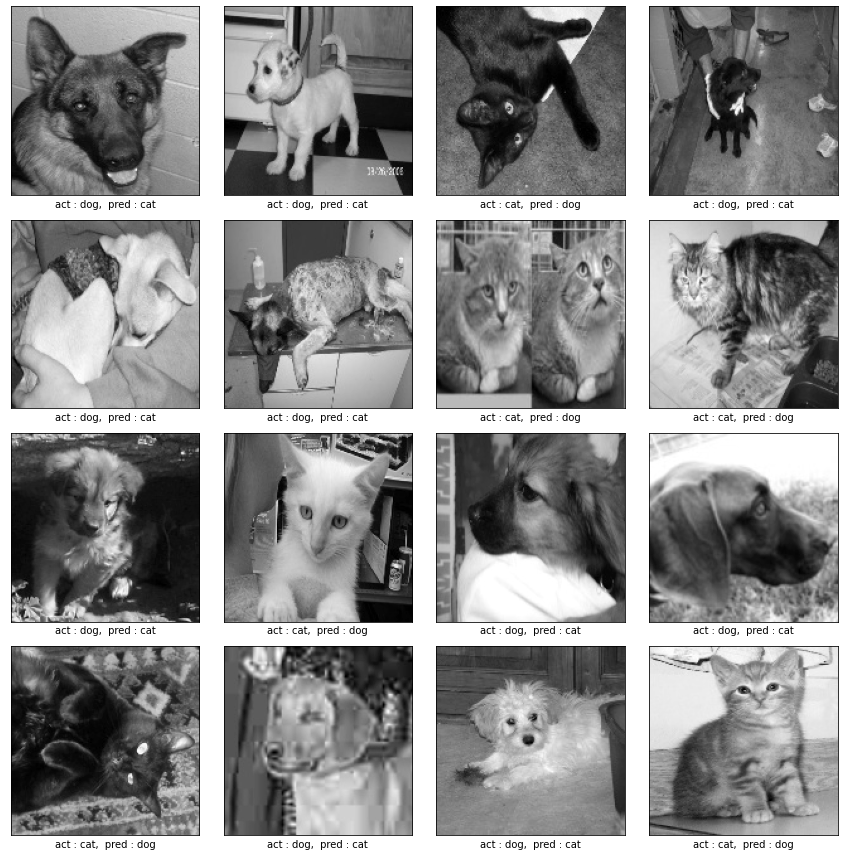

In [19]:
idx = (y_val != pred.reshape(2000,))
x_val_wr = x_val[idx]
y_val_wr = y_val[idx]
pred_wr = pred[idx].reshape(-1,)

x_val_wr = x_val_wr.reshape(-1,150,150)

idx = rd.sample(range(x_val_wr.shape[0]),16)
x_temp = x_val_wr[idx]
y_temp = y_val_wr[idx]
p_temp = pred_wr[idx]
class_name = ['cat','dog']

plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(1-x_temp[i], cmap=plt.cm.binary)
    plt.xlabel(f'act : {class_name[y_temp[i]]},  pred : {class_name[p_temp[i]]}')
plt.tight_layout()
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/CatsDogs/model.h5')

## 5.인터넷에서 이미지를 찾아 테스트해봅시다.

### (1) 이미지 다운받아 구글드라이브에 올리기
* 인터넷에서 고양이/강아지 이미지 몇 개를 다운 받습니다.
* 콜랩, 왼쪽 탭 중 파일 선택하고
* 이미지를 드래그 & 드롭으로 업로드

### (2) 이미지 전처리

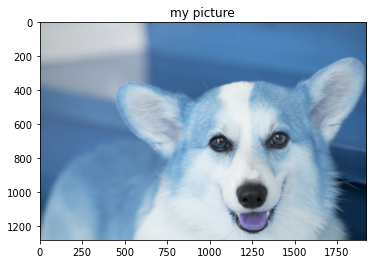

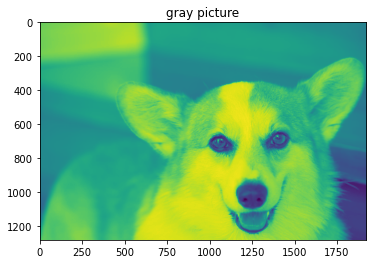

In [40]:
# 아래 file_name을 여러분이 업로드한 파일 이름으로 수정합니다.
file_name = 'dog_01.jpg'

# 업로드한 이미지 확인하기
from matplotlib import pyplot as plt
import cv2

img =  cv2.imread('./dog_01.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.title('my picture')
plt.show()

plt.imshow(gray)
plt.title('gray picture')
plt.show()

(150, 150)


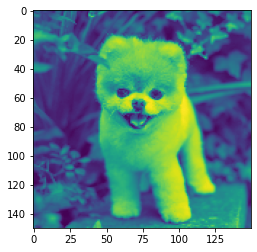

In [45]:
# 아래 file_name을 여러분이 업로드한 파일 이름으로 수정합니다.
file_name = 'dog_02.jpg'

# 이미지 전처리
# 흑백으로 다시 로딩
img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 

# 사이즈 조정
img = cv2.resize(img, (150, 150))               # 크기 맞추기
print(img.shape)
plt.imshow(img)

In [46]:
class_name = ['cat','dog']

# 입력데이터 형식을 갖추기 (train되었던 사진들과 마찬가지로 같은 4차원 shape이어야 예측 가능.)
test_num = img.reshape(1,150,150,1)

# 예측하기(예측된 값이 2차원이어서, 1차원 변환)
pred = model.predict(test_num).reshape(-1,)

# 예측결과 0,1 추출 : pred[0]
# float 타입을 int(정수)로 변환 : int(pred[0])
# class 이름으로 변환 
class_name[int(pred[0])] 

1/1 [==============================] - 0s 35ms/step


'dog'